# Setup for google colab
The file system there works different (cwd is not the same)

In [1]:
import os
import sys

import torch

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB and not "dida_test" in os.listdir(os.getcwd()):
    !git clone https://github.com/michelj5/dida_test

DATA_PATH = os.path.join(os.getcwd(), 'dida_test', 'data') if IN_COLAB else os.path.join(os.getcwd(), 'data')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# Dataset and Data loading

Implement a Dataset class that loads the images from the filesystem.
Decides whether an Image is for testing (`test=True`) based on whether a label image with the same file name exists.
Supports arbitrary (at least from the v2 transforms) transforms.
Some of the older transforms might not work because they have to transform both label and image at once.

For data augmentation we apply a random crop and random mirroring.
This makes the problem of only having 25 images a bit better.


In [2]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image


class LocalImageDataset(Dataset):
    def __init__(self, root_dir, test=False, transform=None, indices=None):
        """
        Create a new Dataset.
        :param root_dir: path to a directory containing 'images' and 'labels' folders with images.
        :param test: loads test images without labels if True, otherwise load images that have labels.
        :param transform: transform to apply to the data.
        :param indices: Indices of the images that will be accessible. Assumed to be a numpy array.
        """
        self.test = test
        self.root_dir = root_dir

        self.image_names = sorted(os.listdir(os.path.join(root_dir, 'images')))
        self.label_names = sorted(os.listdir(os.path.join(root_dir, 'labels')))

        if not self.test:
            # Only use images that also have a label
            self.image_names = np.array([name for name in self.image_names if name in self.label_names])
            self.label_names = np.array(self.label_names)
        else:
            # Only use images without a label
            self.image_names = np.array([name for name in self.image_names if name not in self.label_names])
            self.label_names = None

        # Filter by indices.
        if indices is not None:
            self.image_names = self.image_names[indices]
            self.label_names = self.label_names[indices] if self.label_names is not None else None

        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, 'images', self.image_names[idx])
        image = Image.open(image_name).convert("RGB")
        label = None
        if not self.test:
            label_name = os.path.join(self.root_dir, 'labels', self.label_names[idx])
            label = Image.open(label_name).convert("L")

        if self.transform:
            # Applies the same random transform to both images.
            image, label = self.transform(image, label)

        return image, label

In [3]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader

train_dataset = LocalImageDataset(DATA_PATH,
                                  transform=v2.Compose([
                                      v2.ToImage(),
                                      v2.ToDtype(torch.float32, scale=True),
                                      # These seem to be pretty standard transforms augmentation in segmentation
                                      v2.RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0), antialias=True),
                                      v2.RandomHorizontalFlip(p=0.5),
                                      v2.RandomVerticalFlip(p=0.5),
                                  ]),
                                  )
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = LocalImageDataset(DATA_PATH, transform=None, test=True)

# Metrics for evaluation

* f1, iou, accuracy

In [4]:
from collections import namedtuple

# [true / false] [positive / negative]
Stats = namedtuple("Stats", "tp fp tn fn")


def get_stats(output: torch.Tensor, target: torch.Tensor, threshold: float):
    """
    Computes amount of true/false positives/negatives in a prediction given the label.
    Assumes 4D input tensors and returns statistics as a 1D tensor with one entry for each image.
    :param output: model output
    :param target: label
    :param threshold: values above this will be classified as 1, 0 otherwise
    :return: true positives (tp), false positives (fp), true negatives (tn) and false negatives (fn) as a named tuple.
    """
    output = torch.where(output > threshold, 1.0, 0.0).squeeze(dim=1)
    target = target.squeeze(dim=1)
    true_pos = ((output == 1) & (target == 1)).sum(dim=(1, 2))
    false_pos = ((output == 1) & (target == 0)).sum(dim=(1, 2))
    true_neg = ((output == 0) & (target == 0)).sum(dim=(1, 2))
    false_neg = ((output == 0) & (target == 1)).sum(dim=(1, 2))

    return Stats(true_pos, false_pos, true_neg, false_neg)


def calculate_iou(stats: Stats):
    """
        Intersection over Union score.
        :param stats: statistics acquired from `get_stats`
    """
    return stats.tp / (stats.tp + stats.fn + stats.fp)


def calculate_f1(stats: Stats):
    """
        F1 score.
        When evaluated on a batch of images something funny might happen idk.
        :param stats: statistics acquired from `get_stats`
    """

    precision = stats.tp / (stats.tp + stats.fp)
    recall = stats.tp / (stats.tp + stats.fn)
    f1 = 2 * precision * recall / (precision + recall)
    return f1.nan_to_num()


def calculate_pixel_accuracy(stats: Stats):
    """
        Pixel accuracy (correctly classified pixels over total pixels).
        When evaluated on a batch of images this is the unweighted average of all scores.
        :param stats: statistics acquired from `get_stats`
    """
    return (stats.tp + stats.tn) / (stats.tp + stats.tn + stats.fp + stats.fn)


# Quick testing.
x = torch.tensor([[[[1, 0],
                    [0, 1],
                    [0, 0]]],

                  [[[1, 1],
                    [1, 1],
                    [1, 1]]]])

y = torch.tensor([[[[1, 1],
                    [1, 1],
                    [1, 1]]],

                  [[[1, 1],
                    [1, 1],
                    [1, 1]]]])

stats = get_stats(x, y, 0.5)
print(stats)
print(calculate_iou(stats), calculate_f1(stats), calculate_pixel_accuracy(stats))

Stats(tp=tensor([2, 6]), fp=tensor([0, 0]), tn=tensor([0, 0]), fn=tensor([4, 0]))
tensor([0.3333, 1.0000]) tensor([0.5000, 1.0000]) tensor([0.3333, 1.0000])


# Model and Training

Using the U-Net architecture.
Being fully convolutional, it allows me to train on cropped data that might not be the size of the images I want to test with.




In [5]:
import torch.nn as nn


class DoubleConv(nn.Module):
    """
    Two convolutional layers with batch normalization and ReLU activation.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Up part of UNET
        # *2 because we concatenate the skip connection
        # I think this also assumes the feature sizes to always have a ratio of 2.
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(
                    x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True
                )

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)
        return x


## Training on 20 datapoints and use 5 for test

To find good training parameters, I train on a subset of the labeled images so that I can acquire metrics on the rest of the images that have a label.
For a real application it is probably best to test more different values for parameters, but for computing time reasons and because I am not yet at a point where I understand the optimizer parameters and what good choices would be, I'm keeping most of them at default.

It would also be more meaningful to do multiple splits of the data for the same parameters (like cross validation), but the idea is clear and my gpu is crying.

Also I am not sure If I am freeing gpu memory correctly or if pytorch does everything for me automatically.


In [6]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import numpy as np

test_indices = np.arange(5)
train_indices = np.arange(5, 25)

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
                        v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), antialias=True),
                        v2.RandomHorizontalFlip(p=0.5), v2.RandomVerticalFlip(p=0.5), ])

train_dataset = LocalImageDataset(DATA_PATH,
                                  transform=transform,
                                  indices=train_indices
                                  )
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = LocalImageDataset(DATA_PATH,
                                 transform=transform,
                                 indices=test_indices
                                 )
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)



Training: 100%|██████████| 64/64 [00:31<00:00,  2.05it/s]
C:\Users\julia\AppData\Local\Temp\ipykernel_31036\1161688908.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
Training: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


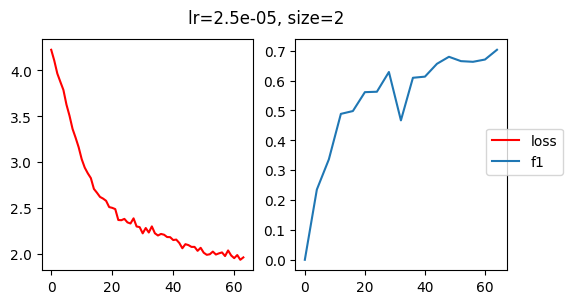

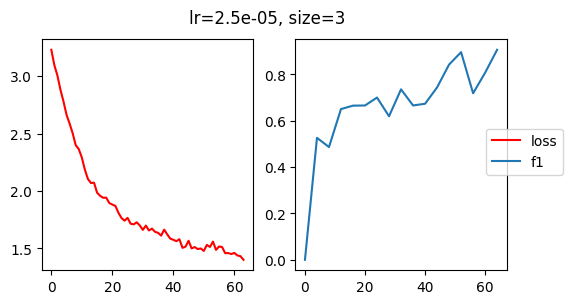

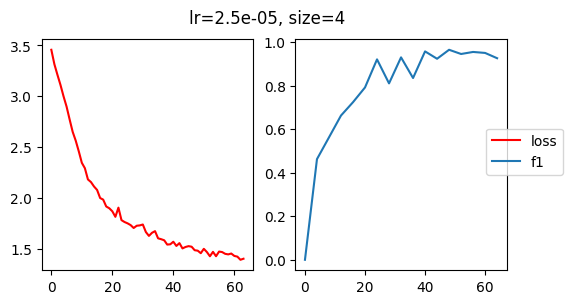

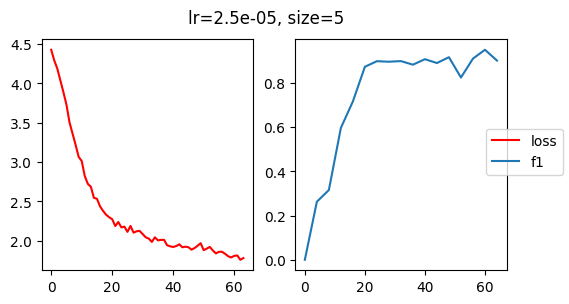

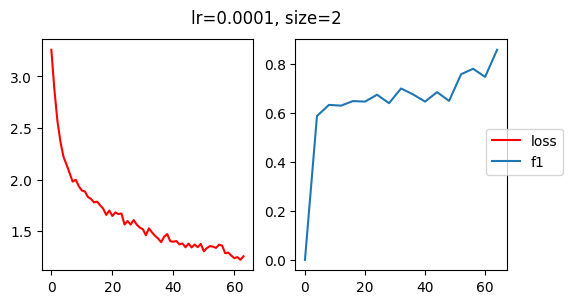

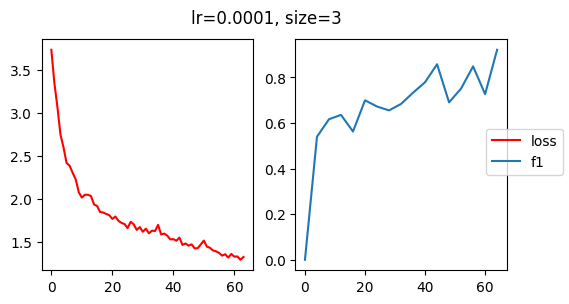

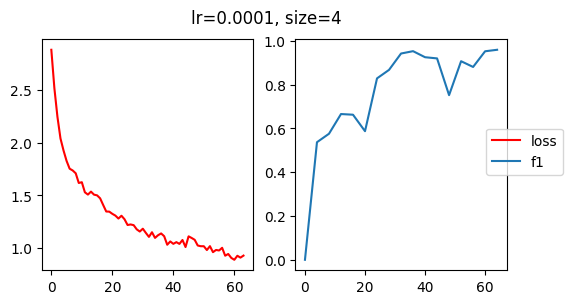

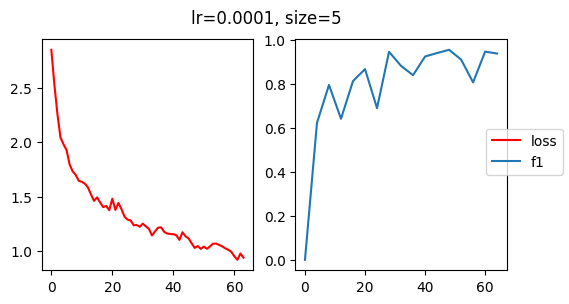

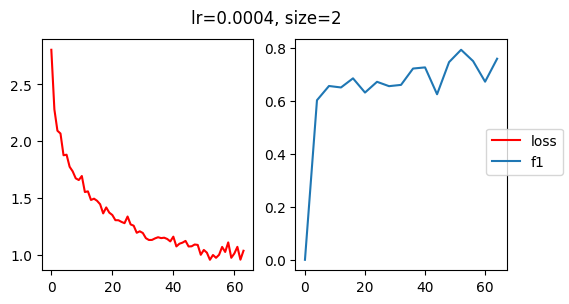

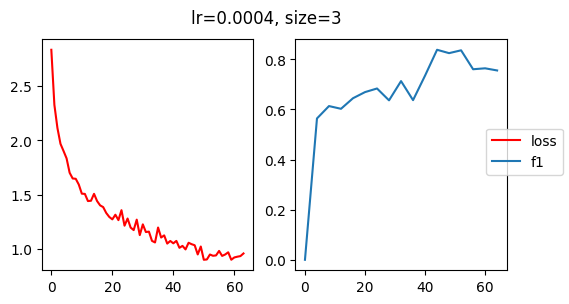

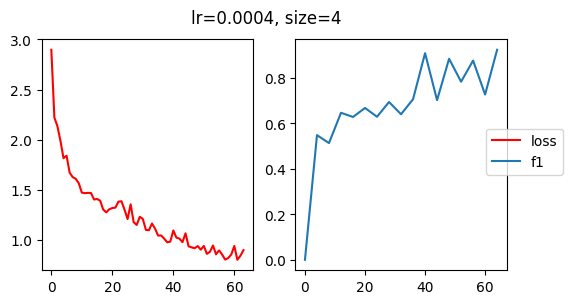

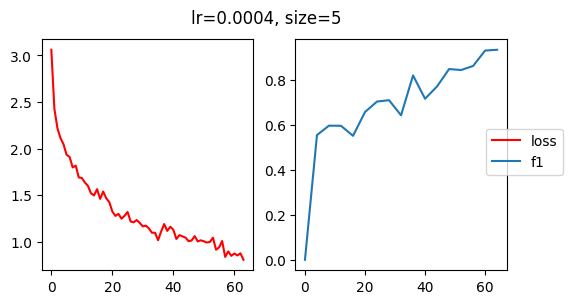

In [13]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Makes progressbar work on my machine, ¯\_(ツ)_/¯
print()
# Initialize model
lrs = [2.5e-5, 1e-4, 4e-4]
model_feature_size = [2, 3, 4, 5]

# Compute metrics only every n-th epoch, they are not going to change that fast
stat_interval = 4

results = dict()

for lr in lrs:
    for size in model_feature_size:
        # We want to record the best score we achieved with each set of parameters and at which epoch
        # so we know when to stop when training the real model
        # I chose f1 because pixel accuracy is a bit pointless because classifying all pixels as 'no roof' achieves a very high score there
        # f1 and iou also correlate very much so I do only one.
        max_f1 = 0
        best_epoch = 0

        # I have always seen this model with increasing powers of 2.
        features = [64 * 2 ** i for i in range(size)]
        model = UNet(features=features).to(device)

        # Loss function, optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training
        num_epochs = 64
        losses = []
        f1s = [0]

        for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training", position=0):
            # total loss recorded this epoch
            epoch_loss = 0
            for images, labels in train_dataloader:
                # Send to gpu
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
            losses.append(epoch_loss)

            if (epoch + 1) % stat_interval == 0:
                # can't shadow function names from above
                f1, iou, acc = 0, 0, 0

                # Don't need gradients for evaluation.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)

                        output = model(images)
                        output = torch.sigmoid(output)

                        # Accumulate metrics.
                        stats = get_stats(output, labels, 0.5)
                        f1 += calculate_f1(stats).sum().item()
                        iou += calculate_iou(stats).sum().item()
                        acc += calculate_pixel_accuracy(stats).sum().item()

                num_img = len(test_dataset)
                f1 = f1 / num_img
                f1s.append(f1)

                if f1 > max_f1:
                    max_f1 = f1
                    best_epoch = epoch

        # Record and plot results.

        results[(lr, size)] = (max_f1, best_epoch)
        fig = plt.figure(figsize=(6, 3))
        (left, right) = fig.subplots(1, 2)
        left.plot(np.array(losses), label="loss", color="red")
        right.plot(np.arange(0, num_epochs + 1, step=stat_interval), np.array(f1s), label="f1")
        fig.legend(loc="center right")
        fig.suptitle(f"lr={lr}, size={size}")
        fig.show()

In [8]:
for key in results.keys():
    (lr, size) = key
    (f1, epoch) = results[key]
    print(f"lr: {lr}, size: {size}: best f1: {f1:.4} at epoch: {epoch}")

lr: 2.5e-05, size: 2: best f1: 0.6502 at epoch: 51
lr: 2.5e-05, size: 3: best f1: 0.6386 at epoch: 59
lr: 2.5e-05, size: 4: best f1: 0.6732 at epoch: 63
lr: 2.5e-05, size: 5: best f1: 0.7226 at epoch: 19
lr: 0.0001, size: 2: best f1: 0.6458 at epoch: 43
lr: 0.0001, size: 3: best f1: 0.6912 at epoch: 19
lr: 0.0001, size: 4: best f1: 0.6864 at epoch: 55
lr: 0.0001, size: 5: best f1: 0.6959 at epoch: 51
lr: 0.0004, size: 2: best f1: 0.6717 at epoch: 51
lr: 0.0004, size: 3: best f1: 0.6911 at epoch: 31
lr: 0.0004, size: 4: best f1: 0.6767 at epoch: 55
lr: 0.0004, size: 5: best f1: 0.6622 at epoch: 59


## Training on full dataset

I am using the results from before.
I feel like this size of model with that many epochs should overfit more heavily considering that there are only 25 Images for training and references in the internet for segmentation I have seen use considerably less epochs with the same model size for tasks with way more data.
But maybe this is because fewer images result in fewer weight updates per epoch.
Also the task might not get less complex (resulting in me needing a less complex model) just because there are less images?



In [9]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# As above but full dataset.
train_dataset = LocalImageDataset(DATA_PATH,
                                  transform=v2.Compose([
                                      v2.ToImage(),
                                      v2.ToDtype(torch.float32, scale=True),
                                      v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), antialias=True),
                                      v2.RandomHorizontalFlip(p=0.5),
                                      v2.RandomVerticalFlip(p=0.5),
                                  ]),
                                  )
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)



In [10]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Makes progressbar work on my machine
print()
# Initialize model
model = UNet(features=[64 * 2 ** i for i in range(4)]).to(device)

# Loss function, optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2.5e-5)

# Training
num_epochs = 64
losses = []

stat_interval = 4
ious = [0]
f1s = [0]
accs = [0]

for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training", position=0, ):
    epoch_loss = 0
    for images, labels in train_dataloader:
        # Send to gpu.
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss)
    if (epoch + 1) % stat_interval == 0:
        f1, iou, acc = 0, 0, 0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            output = torch.sigmoid(output)

            # Calculate metrics.
            # These are evaluated on the training data so not *that* meaningful
            stats = get_stats(output, labels, 0.5)
            f1 += calculate_f1(stats).sum().item()
            iou += calculate_iou(stats).sum().item()
            acc += calculate_pixel_accuracy(stats).sum().item()

        n = len(train_dataset)
        f1s.append(f1 / n)
        ious.append(iou / n)
        accs.append(acc / n)



Training: 100%|██████████| 64/64 [00:50<00:00,  1.26it/s]


C:\Users\julia\AppData\Local\Temp\ipykernel_31036\3790193000.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


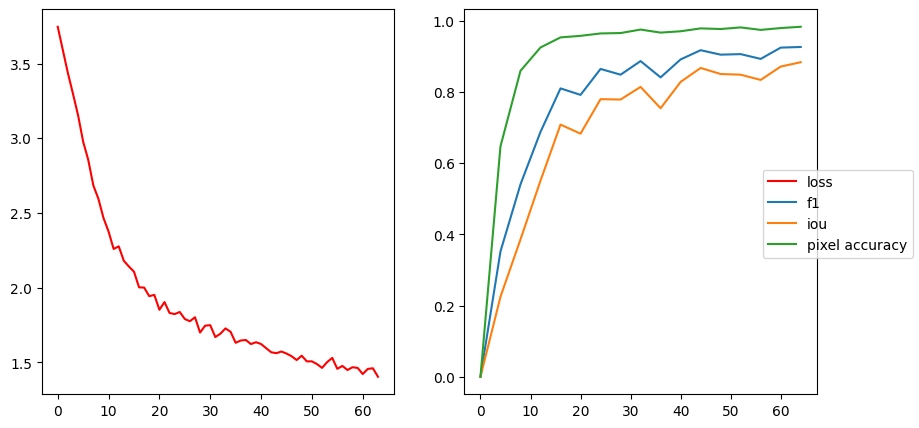

In [11]:
fig = plt.figure(figsize=(10, 5))
(left, right) = fig.subplots(1, 2)
left.plot(np.array(losses), label="loss", color="red")
right.plot(np.arange(0, num_epochs + 1, step=stat_interval), np.array(f1s), label="f1")
right.plot(np.arange(0, num_epochs + 1, step=stat_interval), np.array(ious), label="iou")
right.plot(np.arange(0, num_epochs + 1, step=stat_interval), np.array(accs), label="pixel accuracy")
fig.legend(loc="center right")
fig.show()


# Make predictions

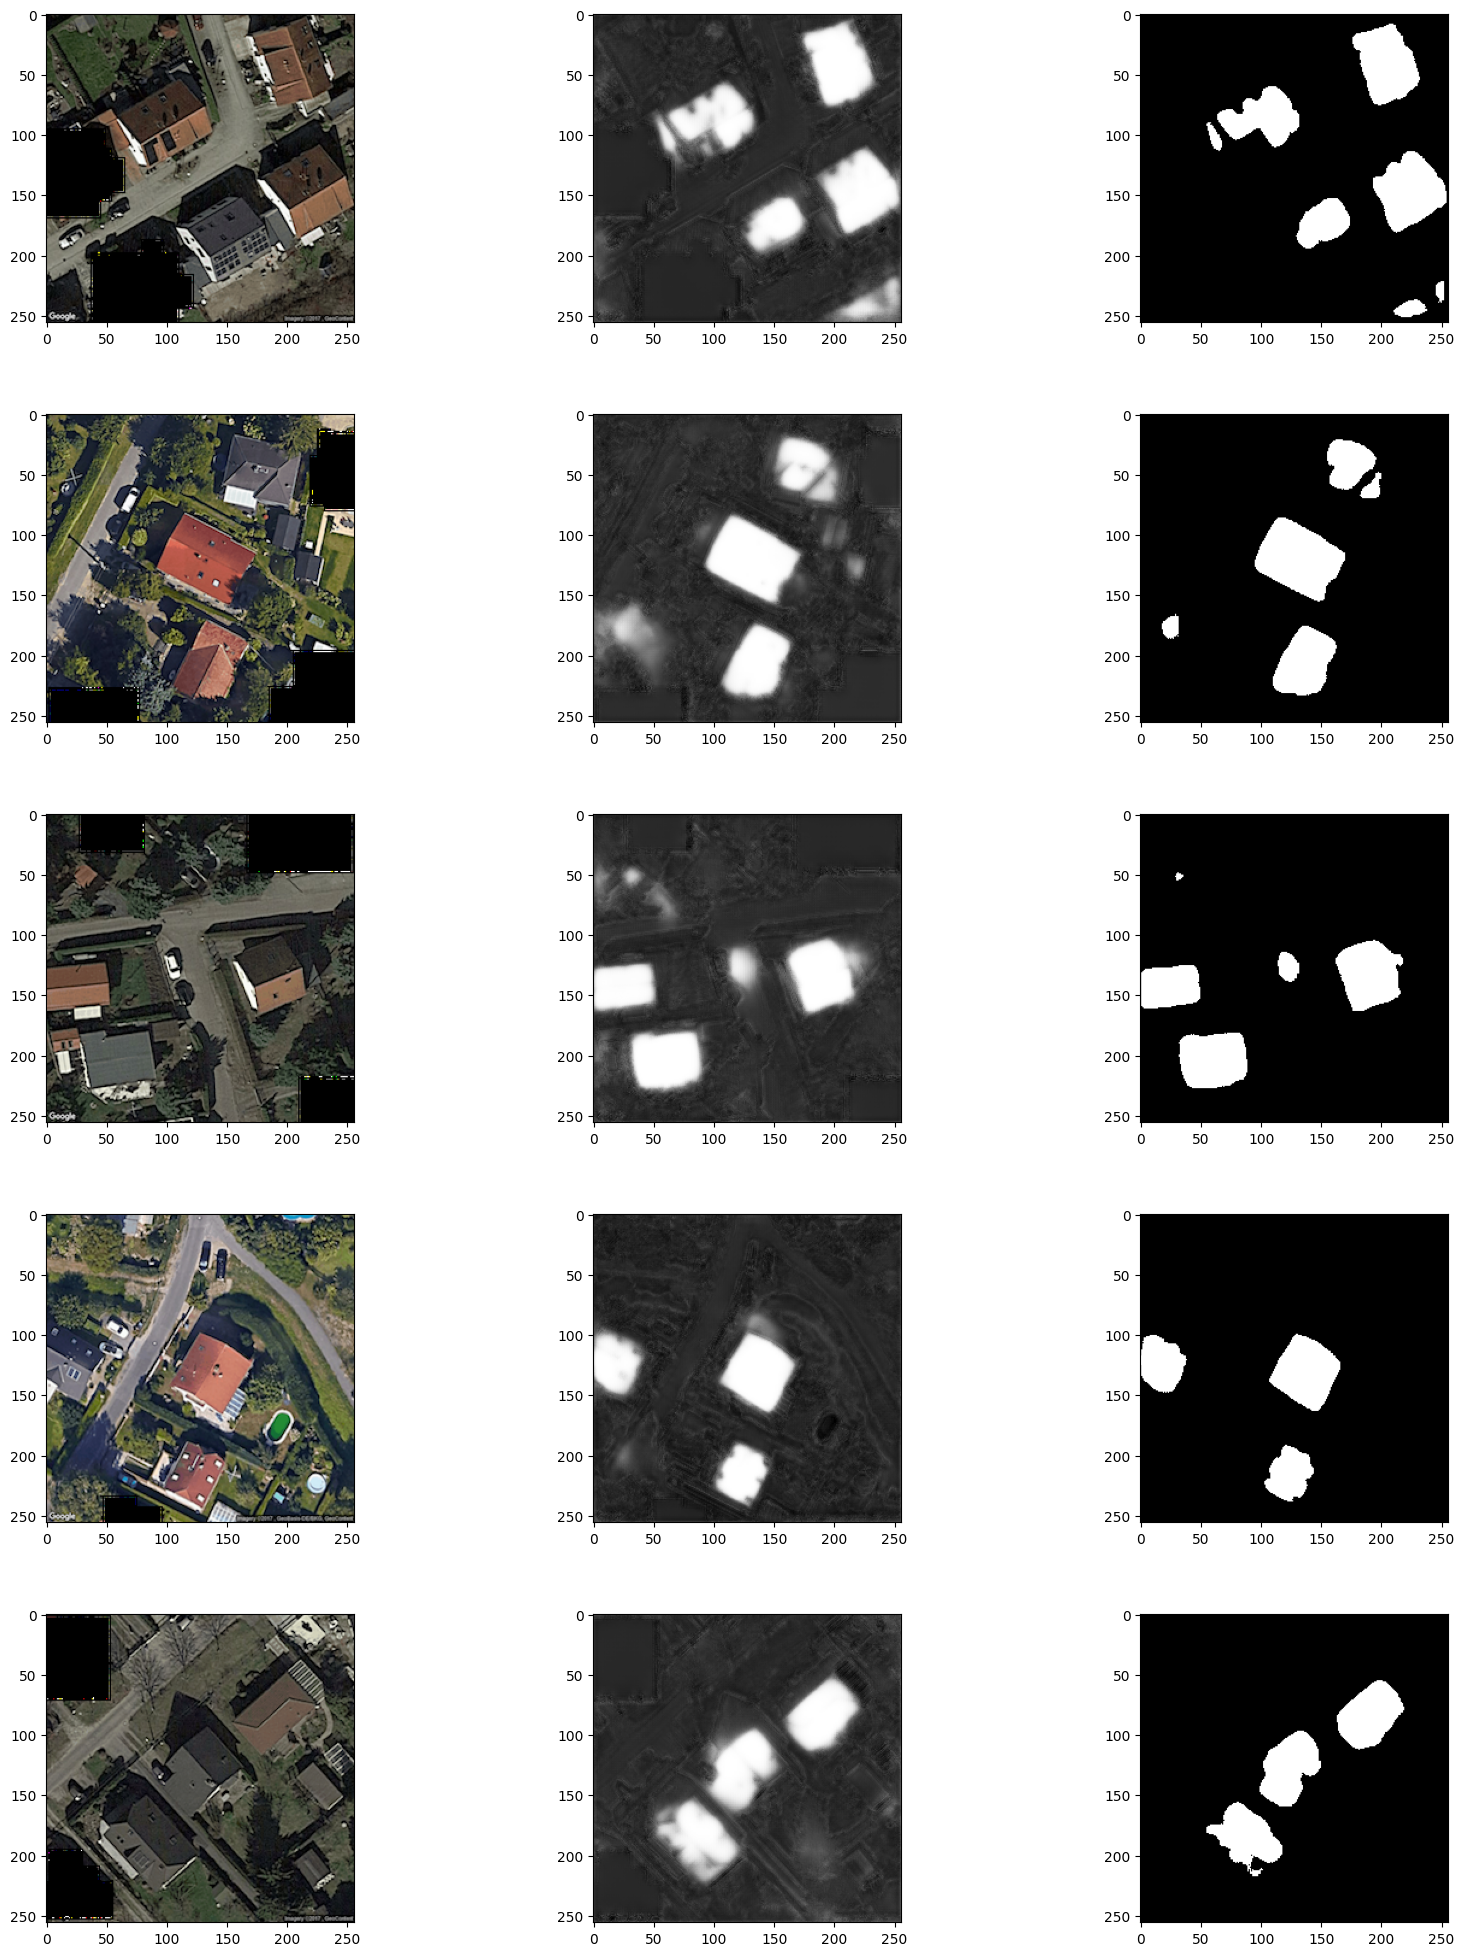

In [12]:
import torch
from torchvision.transforms import v2
from PIL import Image

# Load test images this time.
test_dataset = LocalImageDataset(DATA_PATH, test=True, transform=v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
]))

model.eval()

fig = plt.figure(figsize=(20, 20))
subfigs = fig.subfigures(len(test_dataset), 1)

# Plot all predictions as images.
for (i, (image, _)) in enumerate(test_dataset):
    subfig = subfigs[i]
    (left, center, right) = subfig.subplots(1, 3)

    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        output = torch.sigmoid(output)
        output = output.squeeze()
        # One could probably choose a better threshold.
        binary = torch.where((output > 0.75), 1.0, 0.0)

    left.imshow(image.permute((1, 2, 0)).numpy())
    center.imshow(output.cpu().numpy(), cmap="grey")
    right.imshow(binary.cpu().numpy(), cmap="grey")
